# Машинное обучение

## Лабораторная №1

## Инструменты для подготовки данных

**Выполнили:** Зибров Алексей, Мовчан Игорь, Тенишев Алексей

**Цель работы:** научиться применять инструменты для подготовки данных, проводить первичный анализ.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set(style="darkgrid", palette="deep")

## Часть 1. Реклама

### 1.1 Первичный статистический анализ

Рассмотрим данные, предоставляющие продажи товаров (в тысячах единиц) в зависимости от рекламного бюджета на ТВ, радио и газеты (в тысячах долларов):
- `TV` - затраты на рекламу на телевидение
- `radio` - затраты на рекламу по радио
- `newspaper` - затраты на рекламу в газетах
- `sales` - объем продаж

In [46]:
ad_data = pd.read_csv("advertising.csv")
ad_data

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


Для начала проверим, нет ли отсутствующих значений:

In [47]:
ad_data.isna().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

Все данные целые - можем не беспокоиться о возможных пропусках!

Для удобства разделим целевую переменную и признаки:

In [48]:
sales = ad_data["sales"]
ad_data.drop(columns=["sales"], inplace=True)

Можем приступать к анализу. Для начала вычислим меры центральной тенденции:

In [49]:
print("means:\n", ad_data.mean(), sep="")
print("\nmedians:\n", ad_data.median(), sep="")
print("\nmodes:\n", ad_data.mode(), sep="")

means:
TV           147.0425
radio         23.2640
newspaper     30.5540
dtype: float64

medians:
TV           149.75
radio         22.90
newspaper     25.75
dtype: float64

modes:
      TV  radio  newspaper
0   17.2    4.1        8.7
1   76.4    5.7        9.3
2  109.8    NaN       25.6
3  177.0    NaN        NaN
4  184.9    NaN        NaN
5  197.6    NaN        NaN
6  199.8    NaN        NaN
7  222.4    NaN        NaN
8  237.4    NaN        NaN
9  240.1    NaN        NaN


Видим, что средние рекламные затраты в телевидении во много раз больше затрат на радио и в газетах. Пока лишь можем предположить, что это либо связано с приоритетностью направления во многих ситуациях, либо же общей ценовой политикой в этой сфере, однако уже стоит задуматься о нормировке признаков к чему-то единому, что с большой долей вероятности даст хорошую прибавку в качестве многих моделей. 

Заметим ещё сильное смещения по медиане и среднему в `newspaper`, говорящие о косости его распределения, которое, скорее всего, стоит отнормировать.

Кстати говоря, о приоритетности `TV` говорит и его высокая корреляция с целевыми значениями `sales`:

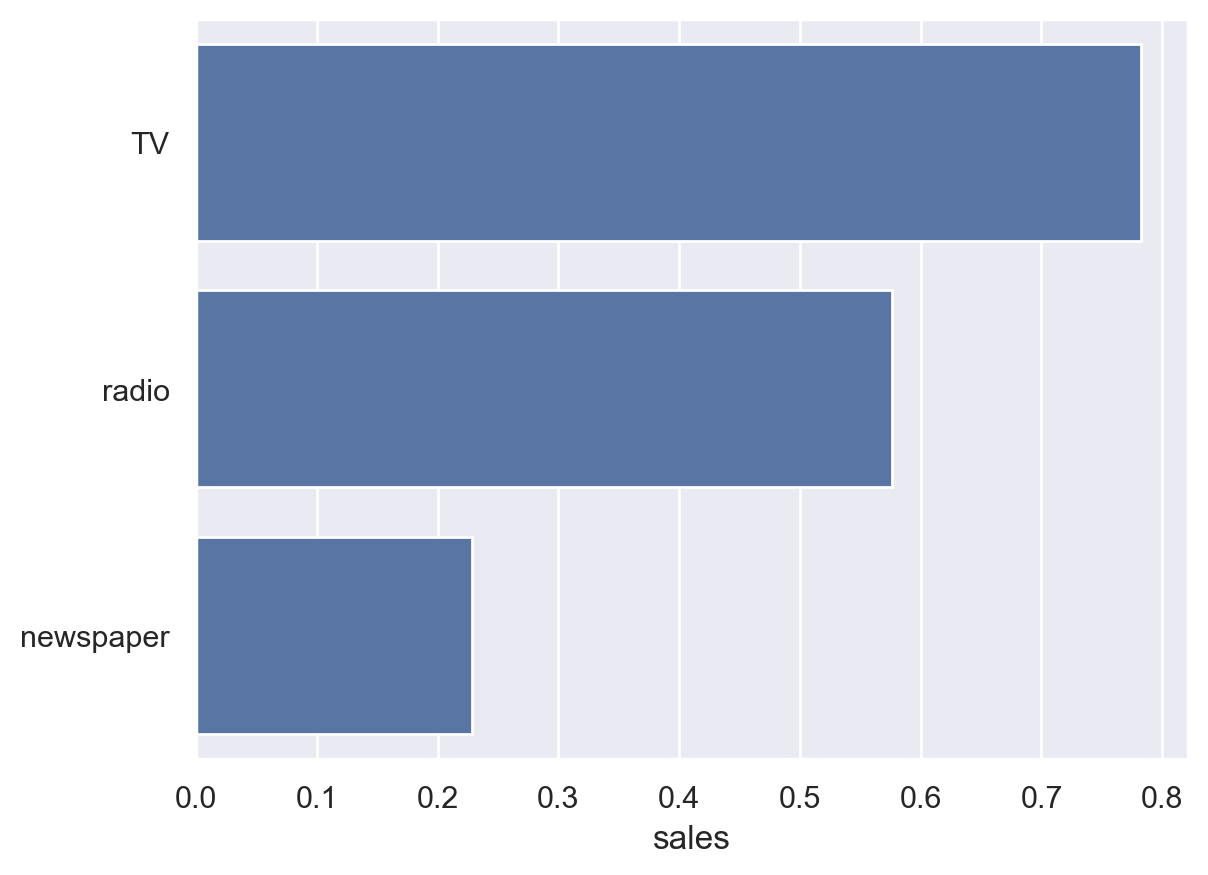

In [50]:
x = ad_data.corrwith(sales)

sns.barplot(x = x, y = x.index)
plt.ylabel("")
plt.xlabel("sales");

Посмотрим теперь на меры разброса:

In [51]:
pd.DataFrame({
    "var": ad_data.var(),
    "std": ad_data.std(), 
    "min": ad_data.min(), 
    "max": ad_data.max(), 
    "IQR": ad_data.quantile(0.75) - ad_data.quantile(0.25)
})

,var,std,min,max,IQR
TV,7370.949893,85.854236,0.7,296.4,144.45
radio,220.427743,14.846809,0.0,49.6,26.55
newspaper,474.308326,21.778621,0.3,114.0,32.35


Наблюдаем внушительные значения у `TV`, указывающие на высокую изменчивость затрат на этот вид рекламы среди наблюдений, скорее всего, связанную с выбором стратегии продвижения в зависимости от бюджета, целевой аудитории и прочих факторов (на это указывают и значения `min`, близкие или даже равные 0). В целом относительно своих средних значений высокими являются и средние отклонения для `radio` и `newspaper`, так что про них можно сделать точно такие же выводы. Всё это говорит о том, что добавление нового признака по типу общего бюджета может дать модели неплохую прибавку в точности.

На самом деле, смотря на коэффициенты, уже ясно, что распределения (как минимум, для `TV` и `radio`) будут напоминать равномерные непрерывные. Убедимся в этом, посмотрев на асимметрию, эксцесс и графики:

In [52]:
print("kurtosis:\n", ad_data.kurt(), sep="")
print("\nskewness:\n", ad_data.skew(), sep="")

kurtosis:
TV          -1.226495
radio       -1.260401
newspaper    0.649502
dtype: float64

skewness:
TV          -0.069853
radio        0.094175
newspaper    0.894720
dtype: float64


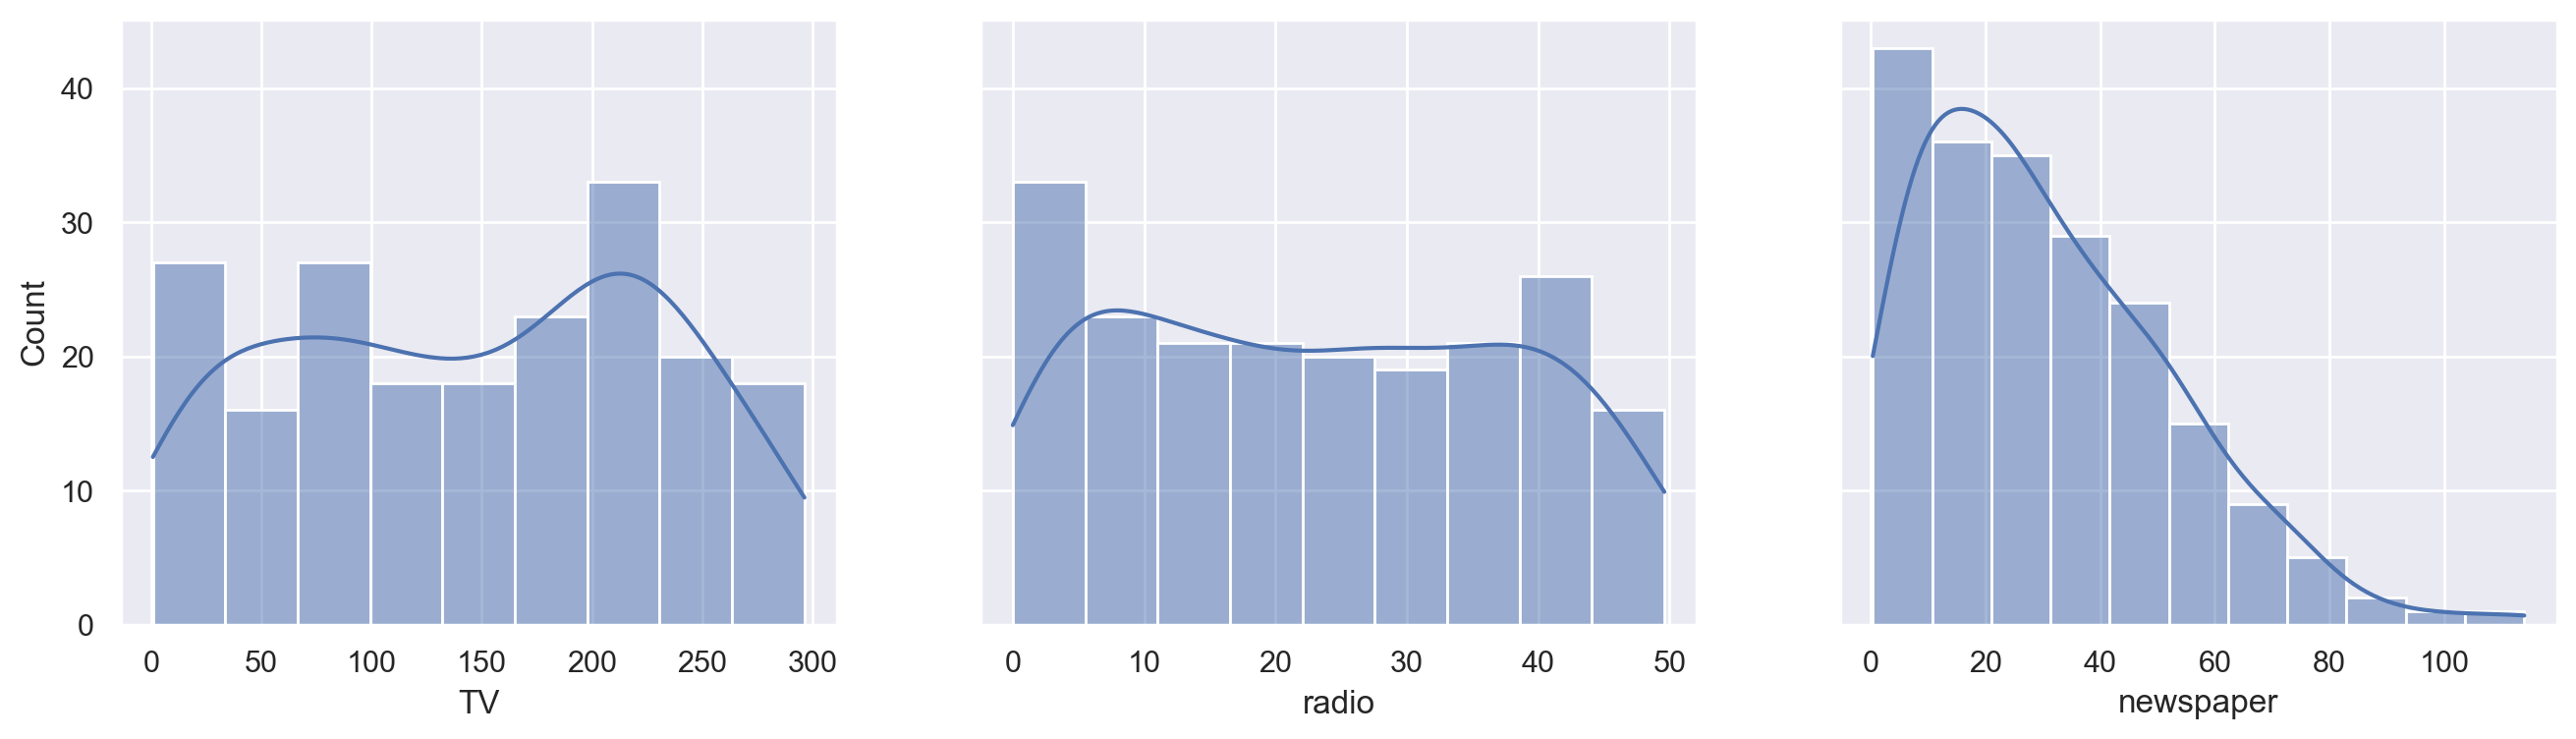

In [53]:
n = len(ad_data.columns)
fig, ax = plt.subplots(figsize=(16, 4), ncols=n, sharey=True)

for i in range(n):
    sns.histplot(ad_data, x=ad_data.columns[i], kde=True, ax=ax[i])

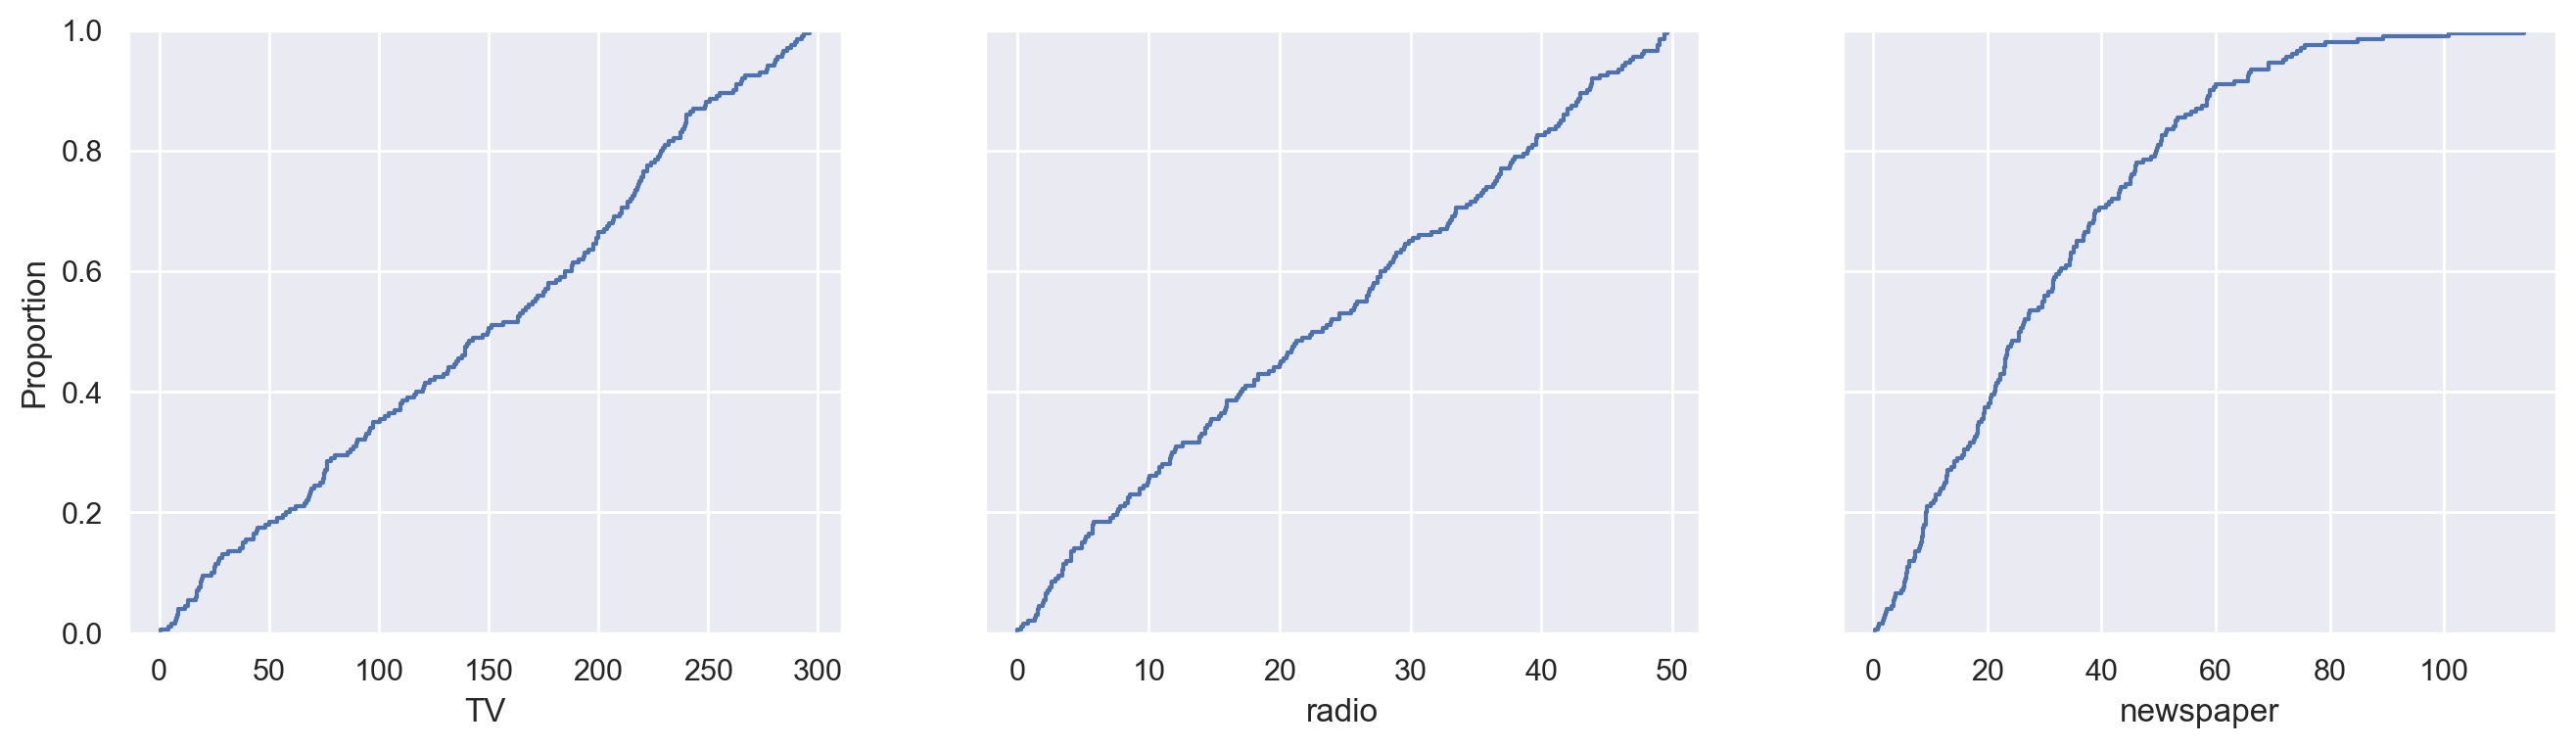

In [54]:
n = len(ad_data.columns)
fig, ax = plt.subplots(figsize=(16, 4), ncols=n, sharey=True)

for i in range(n):
    sns.ecdfplot(ad_data, x=ad_data.columns[i], ax=ax[i])

Как и ожидалось, в случае с `TV` и `radio` имеем равномерное распределение, с `newspaper` - что-то похожее на экспоненциальное. Графически отразим в `pairplot` взаимосвязь признаков между собой и целевыми значениями `sales`.

c:\Users\ventus\miniconda3\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


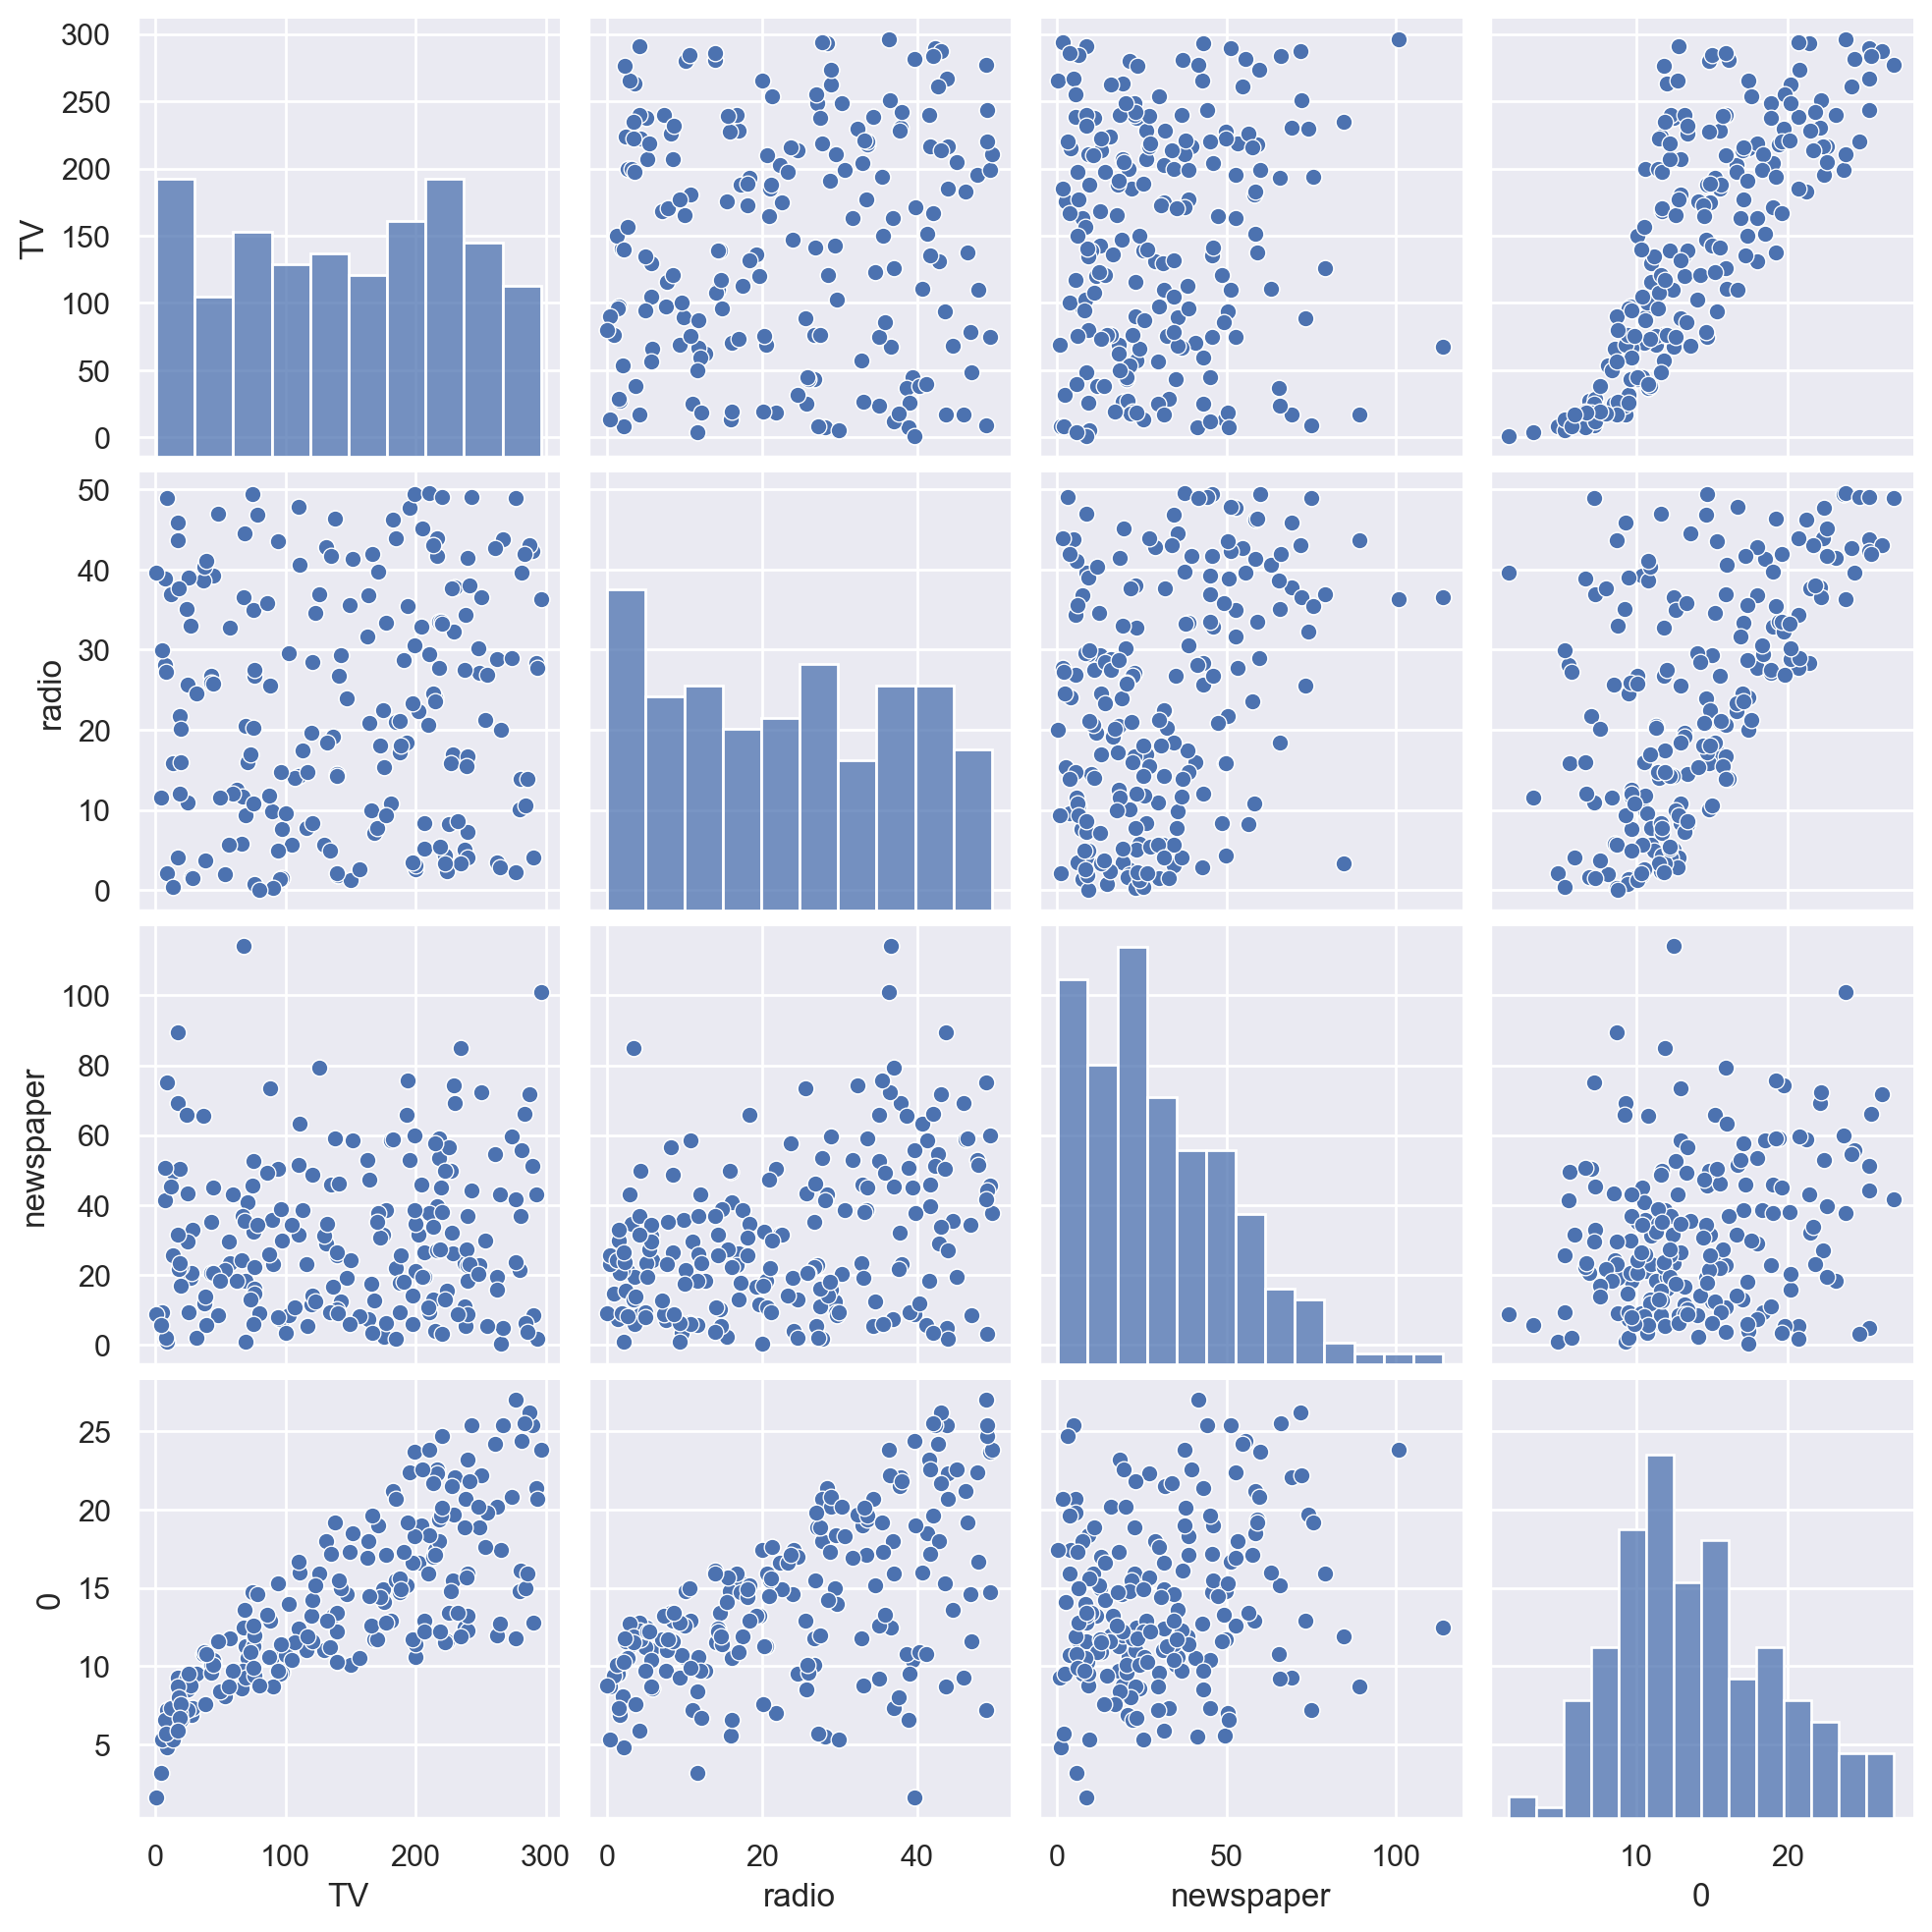

In [55]:
sns.pairplot(pd.concat([ad_data, sales]));

Посмотрим на матрицу корреляций между признаками:

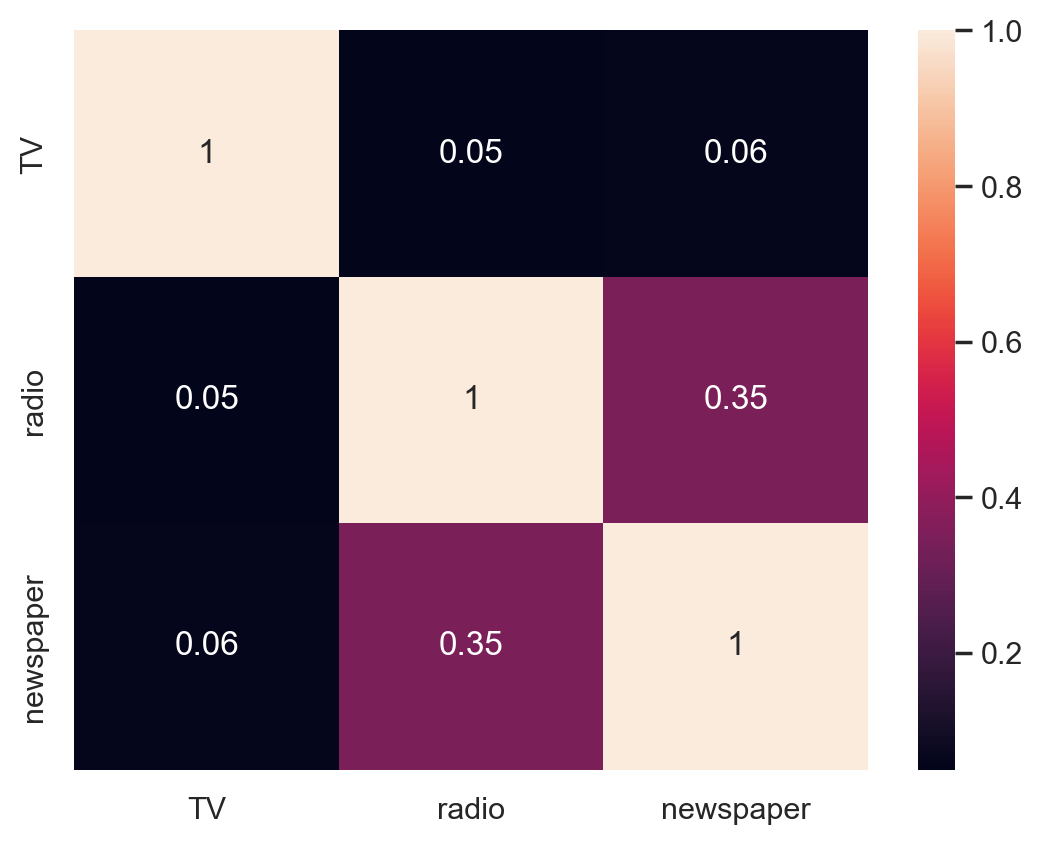

In [56]:
sns.heatmap(ad_data.corr().round(2), annot=True);

Вообще говоря, признаки мало коррелируют между собой, однако `radio` всё же имеет некоторую взаимосвязь c `newspaper`, что можно списать на некоторое пересечение целевых аудиторий.

Из всего анализа также можно сделать вывод, что `TV` влияет на целевые значеня `sales` обособленно и в целом их поднимает.

### 1.2 Извлечение новых признаков

Как уже отмечалось, немаловажным признаком является *общий* бюджет на рекламу, влияющий напрямую на стратегию его продвижения и дальнейшие продажи. Введём его:

In [57]:
ad_data["total"] = ad_data["TV"] + ad_data["radio"] + ad_data["newspaper"]
ad_data.head()

,TV,radio,newspaper,total
0,230.1,37.8,69.2,337.1
1,44.5,39.3,45.1,128.9
2,17.2,45.9,69.3,132.4
3,151.5,41.3,58.5,251.3
4,180.8,10.8,58.4,250.0


Ввёдем долю на каждый вид:

In [58]:
for col in ("TV", "radio", "newspaper"):
    ad_data[f"{col}_share"] = ad_data[f"{col}"]/ad_data["total"]
ad_data.head()

,TV,radio,newspaper,total,TV_share,radio_share,newspaper_share
0,230.1,37.8,69.2,337.1,0.682587,0.112133,0.205280
1,44.5,39.3,45.1,128.9,0.345229,0.304888,0.349884
2,17.2,45.9,69.3,132.4,0.129909,0.346677,0.523414
3,151.5,41.3,58.5,251.3,0.602865,0.164345,0.232789
4,180.8,10.8,58.4,250.0,0.723200,0.043200,0.233600


Введём также полиномиальные признаки, отражающие взаимодействие между `TV`, `radio` и `newspaper`:

In [59]:
spheres = ("TV", "radio", "newspaper")
for i in range(len(spheres)):
    col1 = spheres[i]
    for j in range(len(spheres)):
        col2 = spheres[j]
        ad_data[f"{col1}_{col2}"] = ad_data[f"{col}"]*ad_data[f"{col2}"]
ad_data.head()

,TV,radio,newspaper,total,TV_share,radio_share,newspaper_share,TV_TV,TV_radio,TV_newspaper,radio_TV,radio_radio,radio_newspaper,newspaper_TV,newspaper_radio,newspaper_newspaper
0,230.1,37.8,69.2,337.1,0.682587,0.112133,0.205280,15922.92,2615.76,4788.64,15922.92,2615.76,4788.64,15922.92,2615.76,4788.64
1,44.5,39.3,45.1,128.9,0.345229,0.304888,0.349884,2006.95,1772.43,2034.01,2006.95,1772.43,2034.01,2006.95,1772.43,2034.01
2,17.2,45.9,69.3,132.4,0.129909,0.346677,0.523414,1191.96,3180.87,4802.49,1191.96,3180.87,4802.49,1191.96,3180.87,4802.49
3,151.5,41.3,58.5,251.3,0.602865,0.164345,0.232789,8862.75,2416.05,3422.25,8862.75,2416.05,3422.25,8862.75,2416.05,3422.25
4,180.8,10.8,58.4,250.0,0.723200,0.043200,0.233600,10558.72,630.72,3410.56,10558.72,630.72,3410.56,10558.72,630.72,3410.56


### 1.3 Преобразование признаков

Применим Z-преобразование:
$$
x_{new} = \frac{x-\mu}{\sigma}
$$

Таким образом переведём каждый признак к распределению со нулевым средним 0 и единичной дисперсией, что позволит моделям, чувствительным к выбросам, давать лучшие результаты, а также устранить влияние разных масштабов признаков.

In [60]:
ad_data = (ad_data - ad_data.mean())/ad_data.std()
ad_data.head()

,TV,radio,newspaper,total,TV_share,radio_share,newspaper_share,TV_TV,TV_radio,TV_newspaper,radio_TV,radio_radio,radio_newspaper,newspaper_TV,newspaper_radio,newspaper_newspaper
0,0.967425,0.979066,1.774493,1.465174,0.020627,-0.234639,0.188133,2.325078,1.909778,1.815599,2.325078,1.909778,1.815599,2.325078,1.909778,1.815599
1,-1.194379,1.080097,0.667903,-0.773892,-1.528446,1.223583,1.213809,-0.531991,1.010532,0.337304,-0.531991,1.010532,0.337304,-0.531991,1.010532,0.337304
2,-1.512360,1.524637,1.779084,-0.736252,-2.517146,1.539726,2.444664,-0.699315,2.512356,1.823032,-0.699315,2.512356,1.823032,-0.699315,2.512356,1.823032
3,0.051919,1.214806,1.283185,0.542447,-0.345438,0.160358,0.383256,0.875564,1.696826,1.082314,0.875564,1.696826,1.082314,0.875564,1.696826,1.082314
4,0.393196,-0.839507,1.278593,0.528466,0.207114,-0.756128,0.389005,1.223761,-0.206876,1.076041,1.223761,-0.206876,1.076041,1.223761,-0.206876,1.076041


### 1.4 Отбор признаков и объектов

Посмотрим, есть ли у нас сильно зависимые признаки:

In [61]:
corr_matrix = ad_data.corr().abs() > 0.8
corr_matrix

,TV,radio,newspaper,total,TV_share,radio_share,newspaper_share,TV_TV,TV_radio,TV_newspaper,radio_TV,radio_radio,radio_newspaper,newspaper_TV,newspaper_radio,newspaper_newspaper
TV,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
radio,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
newspaper,False,False,True,False,False,False,False,False,True,True,False,True,True,False,True,True
total,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
TV_share,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
radio_share,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
newspaper_share,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False
TV_TV,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False
TV_radio,False,False,True,False,False,False,False,False,True,True,False,True,True,False,True,True
TV_newspaper,False,False,True,False,False,False,False,False,True,True,False,True,True,False,True,True


Отберём их:

In [62]:
upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
to_drop = [column for column in upper_triangle.columns if (upper_triangle[column] > 0.8).sum() > 0]
ad_data.drop(columns=to_drop, inplace=True)

Также проведём небольшие тестирования:

In [63]:
# тестирование на сырых данных
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score

ad_data_temp = pd.read_csv("advertising.csv")
sales_temp = ad_data_temp["sales"]
ad_data_temp.drop(columns=["sales"], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(ad_data_temp, sales_temp, test_size=0.2, random_state=1)
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Test r2 = %.4f" % r2_score(y_test, y_pred))

Test r2 = 0.8928


In [64]:
# тестирование на преобразованных данных
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(ad_data, sales, test_size=0.2, random_state=1)
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Test r2 = %.4f" % r2_score(y_test, y_pred))

Test r2 = 0.9716


## Часть 2. Сердечные заболевания

### 2.1 Первичный статистический анализ

Подготовка данных:

In [65]:
heart_data = pd.read_csv("heart.csv")
heart_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Разделение на признаки и результат:

In [66]:
target = heart_data["target"]
heart_data.drop(columns=["target"], inplace=True)

Проверка на Nan:

In [67]:
heart_data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

Видим, что пробелы отсутствуют, поэтому можем спокойно работать с данными.

Для удобства дальнейшего исследования отберём числовые значения:

In [68]:
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = heart_data.columns.drop(numeric_features).tolist()
numeric_data = heart_data[numeric_features]

И проверим корреляцию признаков с результирующими значениями:

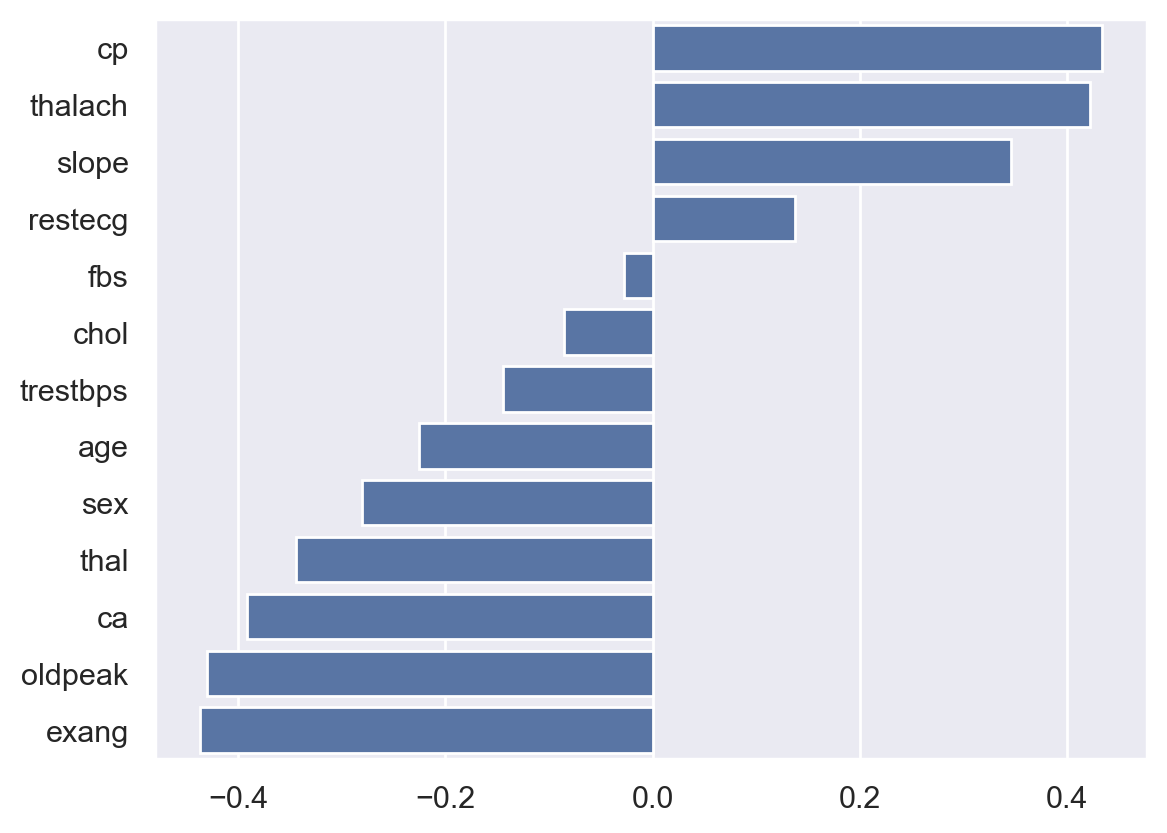

In [69]:
correlations = heart_data.corrwith(target).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plt.xlabel("")
plt.ylabel("");

Признаки `cp` и `exang`, указывающие на наличие болей в грузи и ангины соотвественно, больше всего коррелируют с `target`.

Посмотрим теперь на статистики числовых признаков, а также их гистограммы:

In [70]:
pd.DataFrame({
    "var": numeric_data.var(),
    "std": numeric_data.std(), 
    "min": numeric_data.min(), 
    "max": numeric_data.max(), 
    "IQR": numeric_data.quantile(0.75) - numeric_data.quantile(0.25)
})

,var,std,min,max,IQR
age,82.484558,9.082101,29.0,77.0,13.5
trestbps,307.586453,17.538143,94.0,200.0,20.0
chol,2686.426748,51.830751,126.0,564.0,63.5
thalach,524.646406,22.905161,71.0,202.0,32.5
oldpeak,1.348095,1.161075,0.0,6.2,1.6


In [71]:
print("kurtosis:\n", numeric_data.kurt(), sep="")
print("\nskewness:\n", numeric_data.skew(), sep="")

kurtosis:
age        -0.542167
trestbps    0.929054
chol        4.505423
thalach    -0.061970
oldpeak     1.575813
dtype: float64

skewness:
age        -0.202463
trestbps    0.713768
chol        1.143401
thalach    -0.537410
oldpeak     1.269720
dtype: float64


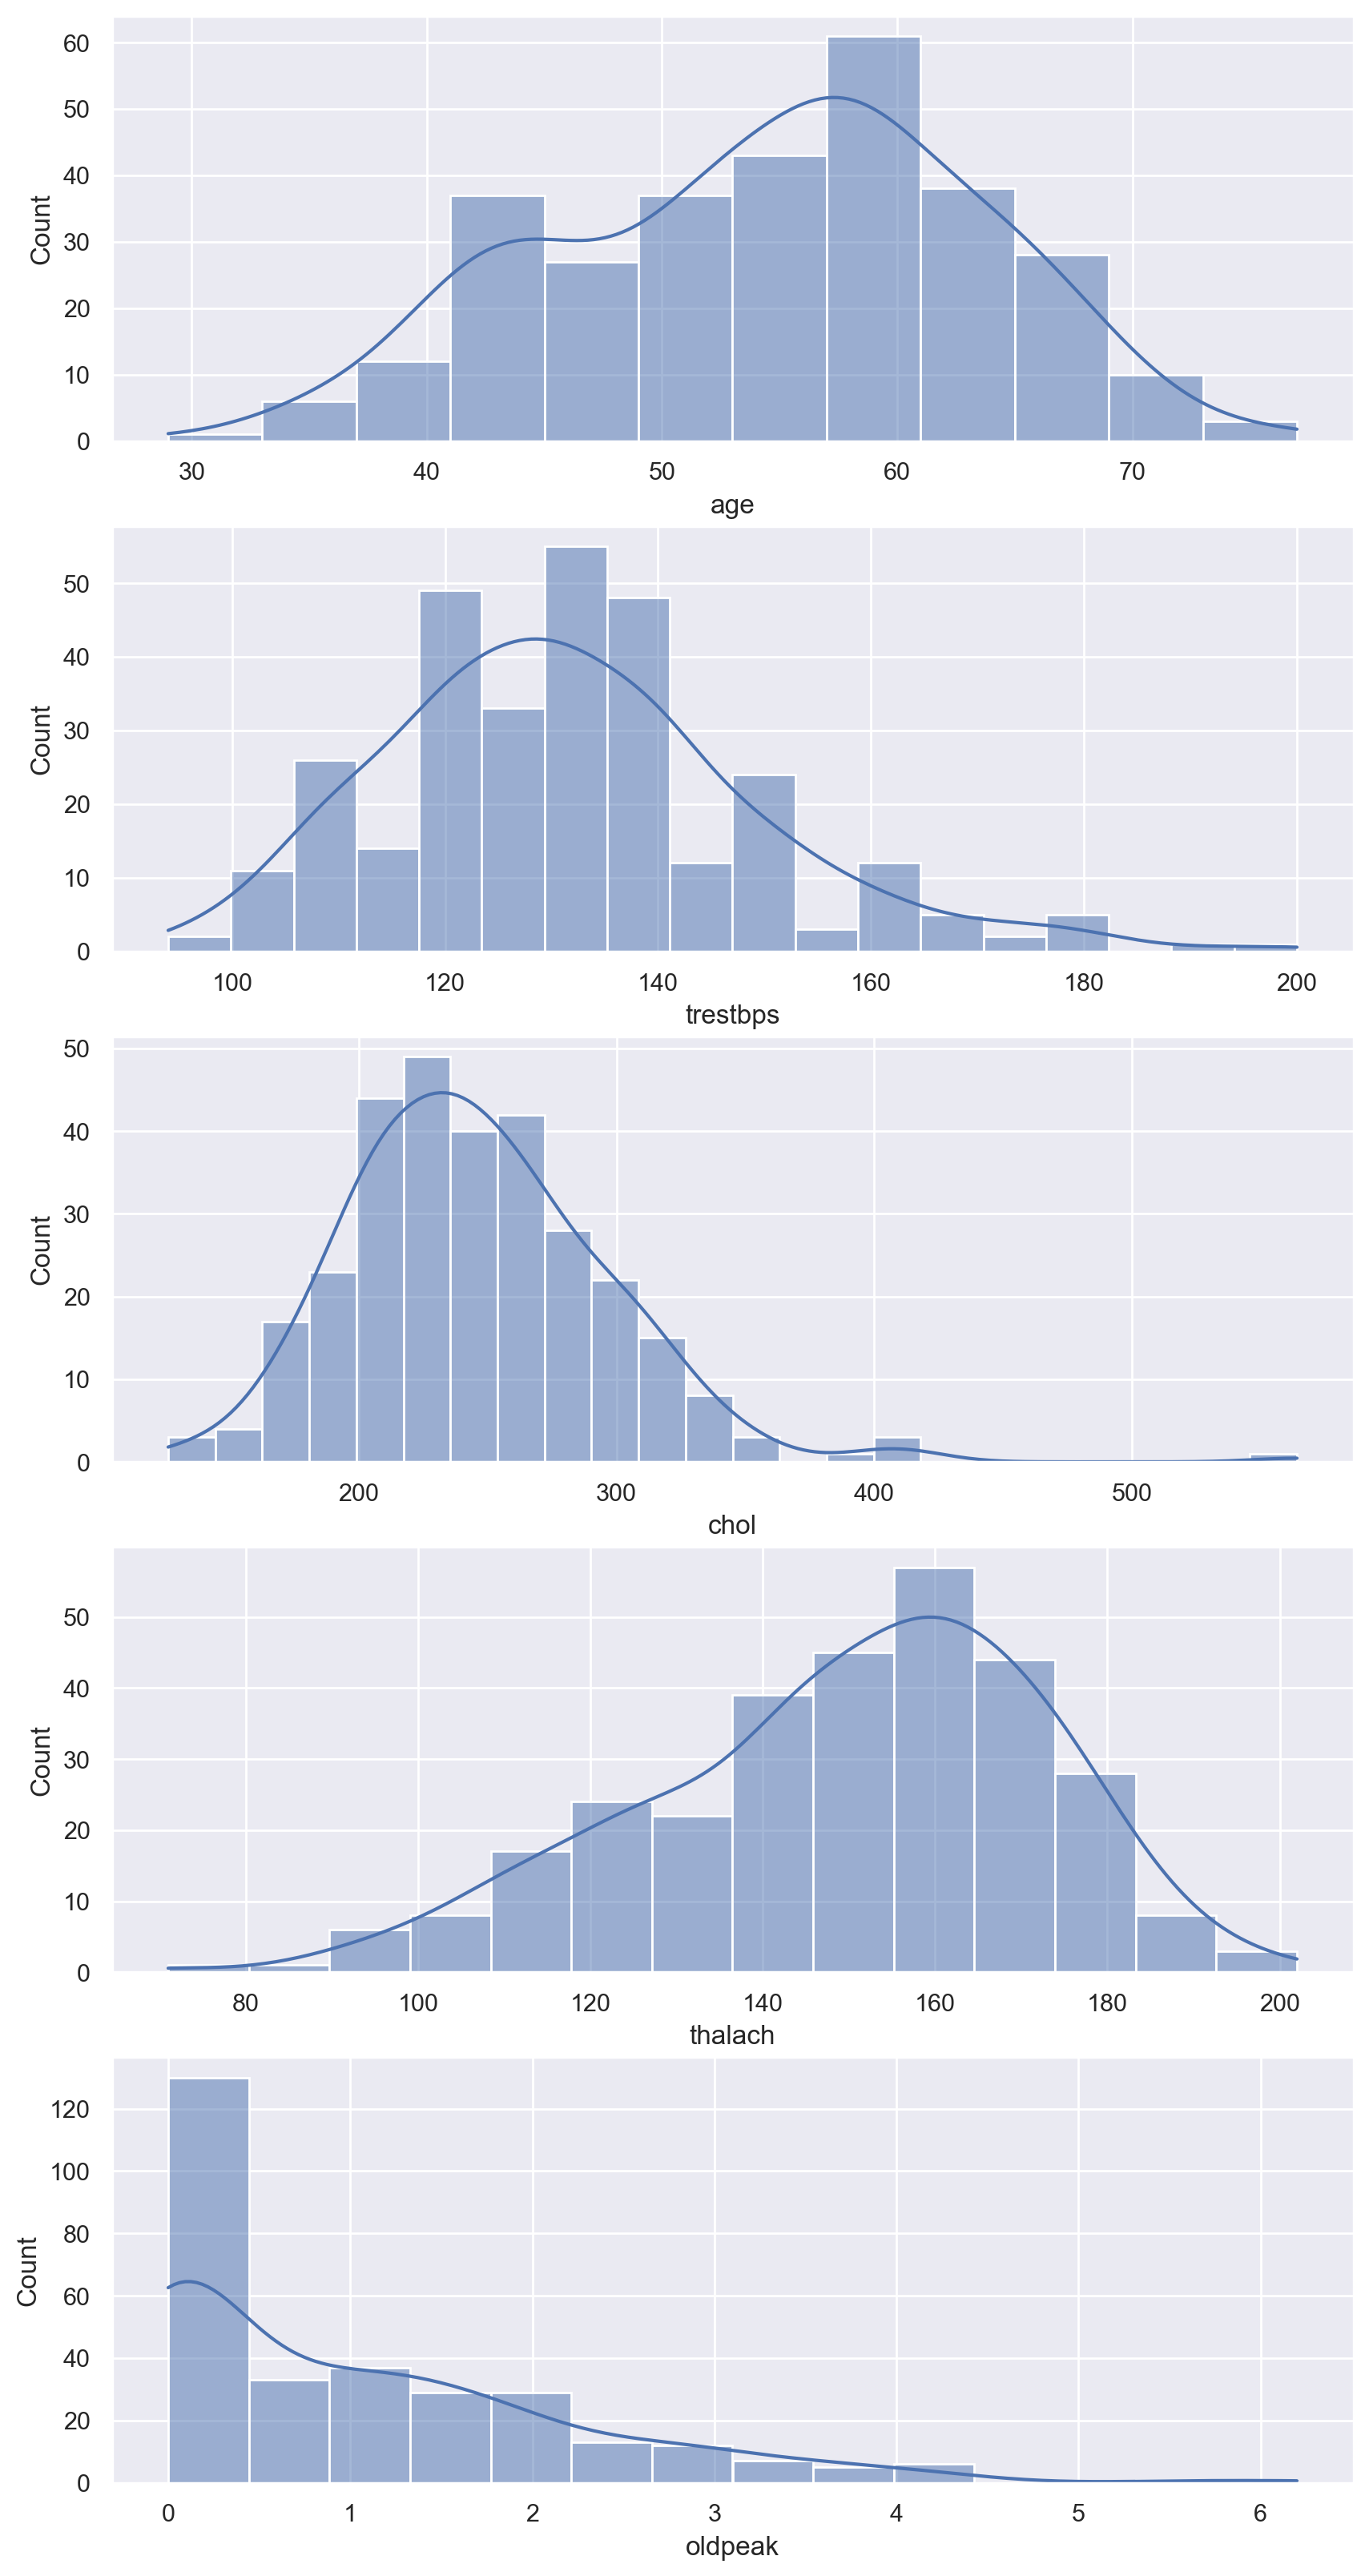

In [72]:
n = len(numeric_data.columns)
fig, ax = plt.subplots(figsize=(10, 20), nrows=n)

for i in range(n):
    sns.histplot(numeric_data, x=numeric_data.columns[i], kde=True, ax=ax[i])

Можем заметить, что, вообще говоря, все признаки, кроме `oldpeak`, у которого присутствуют скопления возле 0, распределены околонормальным образом, а это часто положительно влияет на результаты моделирований.

Отметим также аномально высокие значения признака `chol` и `trestbps`, влияние которых следовало бы минимизировать, например, с помощью z-scaling.

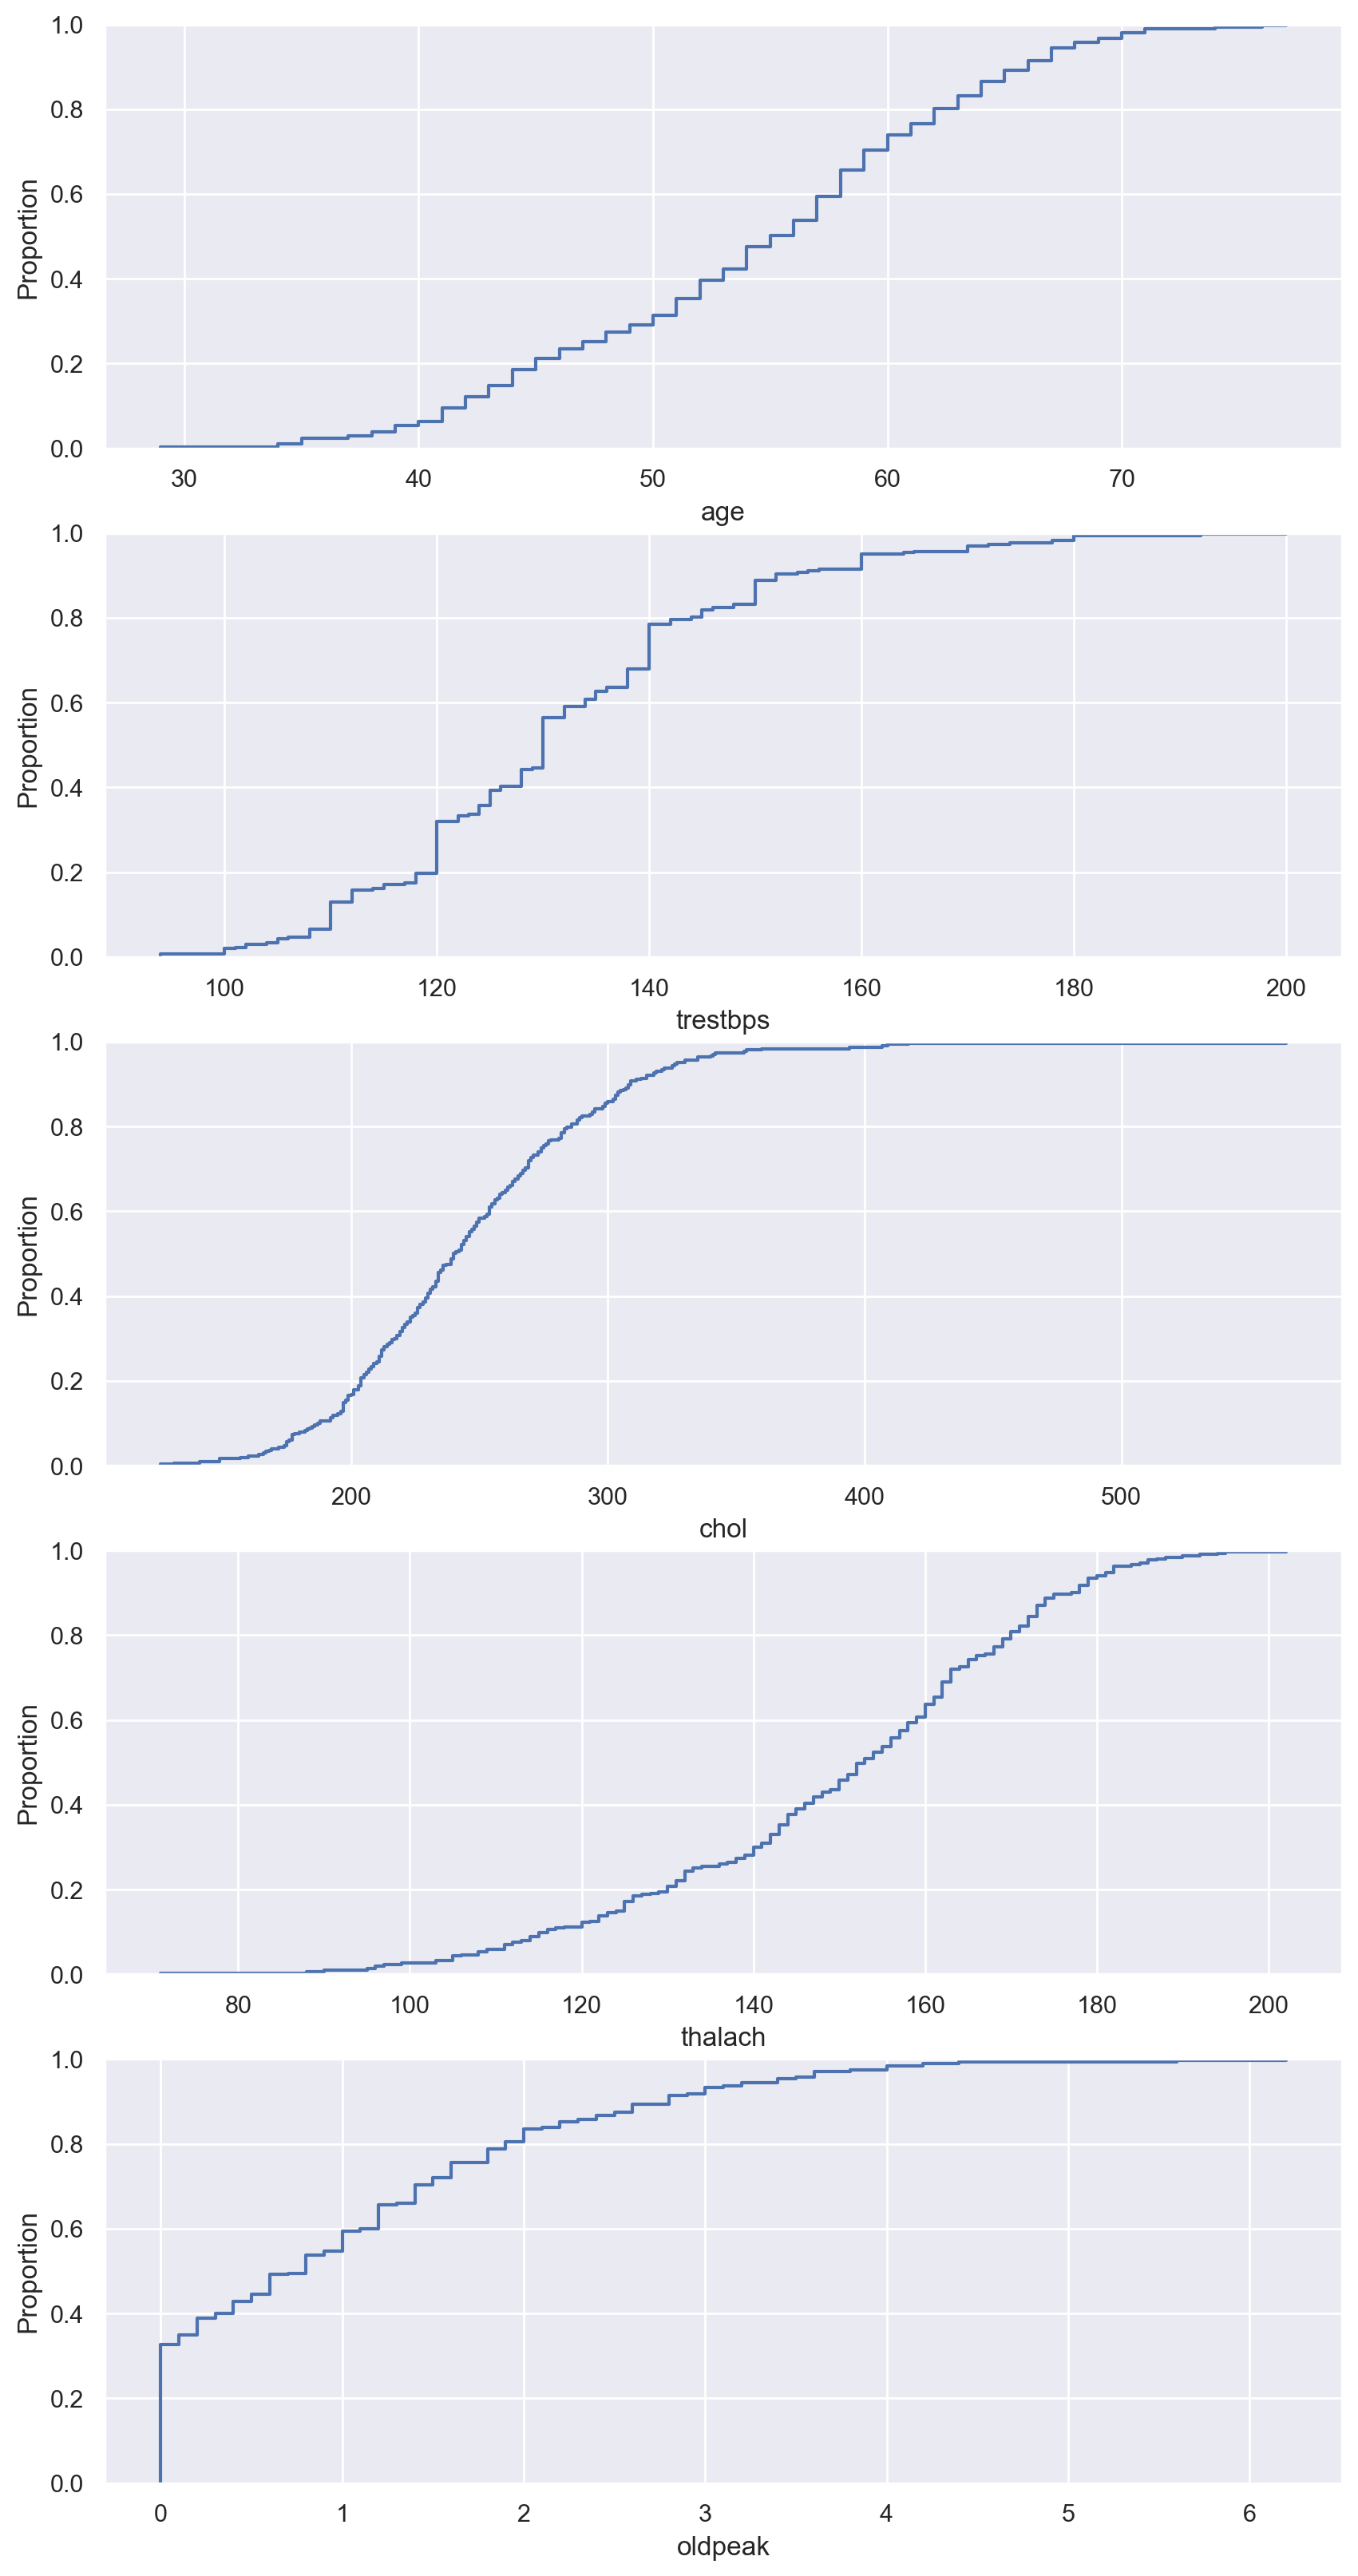

In [73]:
n = len(numeric_data.columns)
fig, ax = plt.subplots(figsize=(10, 20), nrows=n)

for i in range(n):
    sns.ecdfplot(numeric_data, x=numeric_data.columns[i], ax=ax[i])

Из `ecdf` и гистограмм наблюдаем большое количество значений признака `oldpeak`, сосредоточенных возле 0 (лучшим образом показано как раз на кумуляте), однако это скорее не выбросы, а особенности результатов исследований (так как `oldpeak` отражает разность пиковых значений кардиограмм в покое и движении, то часто у здоровых людей при минимальных физических нагрузках больших скачков не будет; к тому же мы не знаем, что за нагрузки совершались).

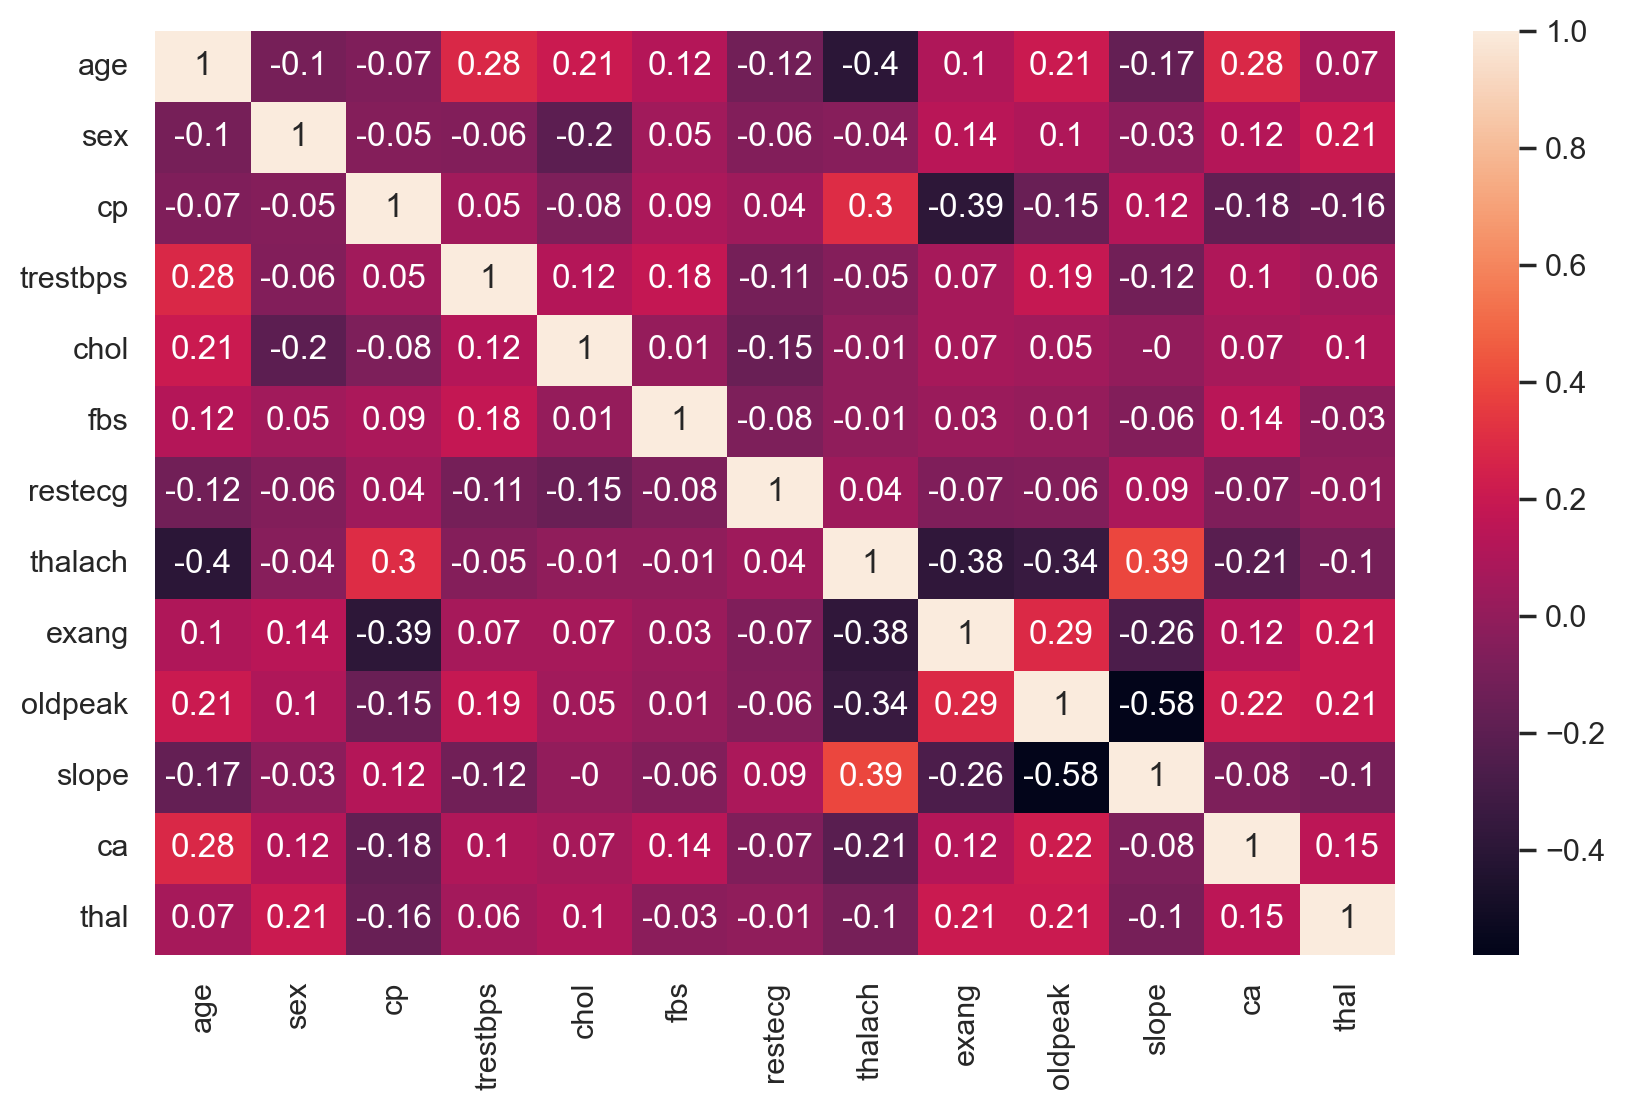

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heart_data.corr().round(2), annot=True);

На `heatmap` все зависимости между признаками приемлемы.

### 2.2 Извлечение новых признаков

Проведём one-hot кодирование категориальных признаков для корректного их представления:

In [75]:
data1_temp = numeric_data.copy()
for category in categorical_features:
    dummies = pd.get_dummies(heart_data[category], prefix=category, dtype=int)
    data1_temp = pd.concat([data1_temp, dummies], axis=1)
heart_data = data1_temp
heart_data.head()

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,0,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0


### 2.3 Преобразование признаков

Также проведём Z-преобразование численных признаков:

In [76]:
heart_data[numeric_features] = (heart_data[numeric_features] - heart_data[numeric_features].mean())/heart_data[numeric_features].std()
heart_data

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0.950624,0.762694,-0.255910,0.015417,1.085542,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,-1.912150,-0.092585,0.072080,1.630774,2.119067,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,-1.471723,-0.092585,-0.815424,0.975900,0.310399,1,0,0,1,0,...,1,1,0,0,0,0,0,0,1,0
3,0.179877,-0.662770,-0.198030,1.237849,-0.206364,0,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0
4,0.289984,-0.662770,2.078611,0.582975,-0.378618,1,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.289984,0.477601,-0.101562,-1.163356,-0.723126,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
299,-1.031296,-1.232956,0.342190,-0.770432,0.138144,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
300,1.501157,0.705675,-1.027653,-0.377507,2.032940,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
301,0.289984,-0.092585,-2.223854,-1.512623,0.138144,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1


### 2.4 Отбор признаков и объектов

И отберём сильно коррелирующие между собой численные признаки:

In [77]:
corr_matrix = numeric_data.corr().abs() > 0.8
upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
to_drop = [column for column in upper_triangle.columns if (upper_triangle[column] > 0.8).sum() > 0]
heart_data.drop(columns=to_drop, inplace=True)

В заключение проведём небольшие тесты на сырых и преобразованных данных:

In [78]:
# тест на сырых данных
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

heart_data_temp = pd.read_csv("heart.csv")
target_temp = heart_data_temp["target"]
heart_data_temp.drop(columns=["target"], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(heart_data_temp, target_temp, test_size=0.2, random_state=0)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        27
           1       0.86      0.88      0.87        34

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



c:\Users\ventus\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
# тест на преобразованных данных
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(heart_data, target, test_size=0.2, random_state=0)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.89      0.91      0.90        34

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61



## Часть 3. Загружаем

Сохраним полученные результаты для их дальнейшего использования:

In [80]:
ad_dataset = pd.concat([ad_data, sales], axis=1)
heart_dataset = pd.concat([heart_data, target], axis=1)
display(heart_dataset.sample(5))
ad_dataset.sample(5)

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,target
129,2.161798,-0.662770,0.438658,-1.250673,-0.723126,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
267,-0.590870,-0.776808,-1.876570,-1.032382,-0.206364,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
206,0.510197,-1.232956,-0.140149,-0.333849,0.138144,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
195,0.510197,2.188159,1.538391,-0.421166,2.032940,0,1,1,0,0,...,1,0,0,0,0,0,0,0,1,0
170,0.179877,-0.092585,0.187842,-0.333849,-0.378618,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,0


,TV,radio,newspaper,TV_share,radio_share,TV_TV,sales
81,1.080407,-1.290782,0.291387,0.807666,-0.972484,0.872663,12.3
79,-0.361572,-1.048306,-0.342262,0.514720,-0.686133,-0.393890,11.0
180,0.111322,-1.391814,-1.021828,1.179310,-0.965514,-0.677179,10.5
192,-1.512360,-1.290782,0.048029,-1.620682,-0.496607,-0.832446,5.9
131,1.376257,-1.371608,0.571478,0.800642,-1.012423,1.397222,12.7


In [81]:
ad_dataset.to_csv("ad_dataset.csv", index=False)
heart_dataset.to_csv("heart_dataset.csv", index=False)